In [1]:
import math
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.special as special
import scipy.stats as stats
%matplotlib inline
import toolkit_eric as tke
import os

In [2]:
def get_fname(n, quiet = False):
    dir_list = os.listdir('.')
    filename = None
    for item in dir_list:
        try:
            header = item[:item.find('_')]
            if int(header) == n:
                if quiet == False:
                    print( item )
                filename = item
                break
        except:
            pass
    
    if filename == None:
        print( "get_fname() error: File " + str(n) + " not found!" )
    return filename

def val_var_str(val, var, fstr = 'auto'):
    sig = var**0.5
    if fstr == 'auto':
        o_val = math.floor( math.log10( abs(val) ) )
        o_sig = math.floor( math.log10( abs(sig) ) )
        
        sdig = int(o_val - o_sig + 1)
        # print o_val, o_sig, sdig
        if sdig < 1:
            sdig = 1
        sdig_str = '{:1.0f}'.format( sdig )
        # print sdig_str
        
        val_fmt = '{:.' + sdig_str + 'g}'
        val_var_str = val_fmt.format(val) + ' +/- ' + '{:.1g}'.format(sig)
        return val_var_str
    else:    
        return fstr.format(val) + ' +/- ' + fstr.format(var**0.5)

def mw_scan(filename, n = 3, plot = False):
    # Load Data
    data = np.loadtxt(filename)
    data[:,1] = cav_cuts(data[:,1])
    data = tke.lin_ave(data,n)
    freq = data[:,0]/1.0e9
    amps = data[:,1]
    
    fr_m = freq[ np.argmin(amps) ]
    
    if plot == True:
        plt.plot(freq, amps, 'k-')
        plt.axvline(fr_m, color = 'blue')
        plt.grid(True)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Reflected Power (arb. u.)')
        plt.title('Peak = ' + str(fr_m) + ' GHz')
    
    return freq, amps, fr_m

def cav_cuts(amps, n=5):
    while True:
        damp = abs(np.diff(amps))
        ave = np.mean(damp)
        stdev = np.std(damp)
        i = np.argmax(damp)
        # print i, damp[i], ave + 5*stdev
        
        if damp[i] > ave + n*stdev:
            for j in range(i+1, len(amps)):
                amps[j] = amps[j] * amps[i]/(amps[i] + damp[i])
        else:
            break
    
    return amps

def cav_fit(freq, amps, p0):
    # popt, pcov = optimize.curve_fit(cauchy_5, freq, amps, p0)
    popt, pcov = optimize.curve_fit(cauchy_4, freq, amps, p0)
    # print popt
    # amps_fit = cauchy_5(freq, popt[0], popt[1], popt[2], popt[3], popt[4])
    amps_fit = cauchy_4(freq, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, amps_fit

def cauchy_5(x, amp, width, x0, m, y0):
    return amp*width**2 / ( (x-x0)**2 + width**2 ) + m*(x-x0) + y0

def cauchy_4(x, amp, width, x0, y0):
    return amp*width**2 / ( (x-x0)**2 + width**2 ) + y0

def laser_scan(filename, n = 10, plot = False):
    # Load Data
    data = np.loadtxt(filename)
    data = data[np.argsort(data[:,1]),:]
    data = tke.lin_ave(data, n)
    freq = data[:,1]
    norm = data[:,2]
    no_b = data[:,3]
    sign = data[:,4]
    si_b = data[:,5]
    
    si_n = (sign - si_b)/(norm - no_b)
    
    if plot == True:
        plt.plot(freq, si_n, 'k-')
        plt.grid(True)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Rydberg Signal')
    
    return freq, si_n

# def erfc_4(x, amp, width, x0, y0):
#     return amp/2.0*special.erfc( (x-x0)/width ) + y0

def erfc_4(x, amp, width, x0, y0):
    return 0.5*amp*special.erfc( (x-x0)/(2.0**0.5*width) ) + y0

def fit_erfc_4(freq, si_n, p0):
    popt, pcov = optimize.curve_fit(erfc_4, freq, si_n, p0)
    si_n_fit = erfc_4(freq, popt[0], popt[1], popt[2], popt[3])
    
    return popt, pcov, si_n_fit

def erfc_lin_5(x, amp, width, x0, y0, m):
    return 0.5*amp*special.erfc( (x-x0)/(2.0**0.5*width) ) + y0 + m*(x-x0)

def fit_erfc_lin_5(x, y, p0):
    popt, pcov = optimize.curve_fit(erfc_lin_5, x, y, p0)
    y_fit = erfc_lin_5(x, popt[0], popt[1], popt[2], popt[3], popt[4])
    
    return popt, pcov, y_fit

def erfc_4_amp(x, width, x0, y0):
    return 0.5*hardamp*special.erfc( (x-x0)/(2.0**0.5*width) ) + y0

def fit_erfc_4_amp(freq, si_n, p0):
    
    popt, pcov = optimize.curve_fit(erfc_4_amp, freq, si_n, p0)
    si_n_fit = erfc_4_amp(freq, popt[0], popt[1], popt[2])
    
    return popt, pcov, si_n_fit


# def limit_scan(filename, n = 10, plot = False):
#     freq, si_n = laser_scan(filename, n, False)
#     p0 = (1.0, 10.0, -10.0, 0.0)
#     popt, pcov, si_n_fit = fit_erfc(freq, si_n)
#     
#     if plot == True:
#         plt.plot(freq, si_n, 'k-')
#         plt.plot(freq, si_n_fit, 'b-')
#         plt.xlabel('Frequency (GHz)')
#         plt.ylabel('Signal (arb. u.)')
#         plt.grid(True)
#         plt.title( 'limit = ' + val_var_str(popt[2], pcov[2,2]**0.5)
#                    + ' GHz' )
#     
#     return freq, si_n, np.array([[popt[0], pcov[0,0]**0.5],
#                      [popt[1], pcov[1,1]**0.5],
#                      [popt[2], pcov[2,2]**0.5],
#                      [popt[3], pcov[3,3]**0.5]])

# -----

def dist(step):
    m = 0.0002539 # mm/step
    b = 44.60     # mm
    return 2*m*step + b

def wavelength(step, df):
    m = 0.0002539 # mm/step
    wl = 299792458.0*1.0e3 / (df*1.0e9*1.00029) # wavelength (mm) at 17.8 GHz
    # print wl
    return 2*m*step /wl

# def delay_scan(filename, n, df, plot = False):
#     steps, nsig = tke.dyescan(filename, n)
#     wlng = wavelength(steps, df)
# 
#     wl = 299792458.0*1.0e3 / (df*1.0e9*1.00029) # wavelength (mm) at 17.8 GHz
# 
#     # initial guesses
#     a0_amp   = ( max(nsig) - min(nsig) )/2.0
#     a0_phase = wlng[np.argmax(nsig)]
#     a0_mean  = np.mean(nsig)
#     a0 = np.array([a0_amp, a0_phase, a0_mean])
#     fit, cov = optimize.curve_fit(cos_off, wlng, nsig, a0)
#     a = fit
#     # fitted data
#     fit_y = cos_off(wlng, a[0], a[1], a[2])
# 
#     # printing
#     # print a0
#     # print a
# 
#     # plotting
#     # plt.figure(figsize = (10,10))
#     if plot == True:
#         plt.plot(wlng, nsig, 'b.-')
#         plt.plot(wlng, fit_y, 'k-', linewidth = 3)
#         plt.grid(True)
#     
#     return wlng, nsig, fit_y, cov

def fit_cos_off(wlng, nsig):
    
    # initial guesses
    a0_amp   = ( max(nsig) - min(nsig) )/2.0
#     a0_freq  = 2.0*np.pi
    a0_phase = wlng[np.argmax(nsig)]
    a0_mean  = np.mean(nsig)
    a0 = np.array([a0_amp, a0_phase, a0_mean])
    fit = optimize.curve_fit(cos_off, wlng, nsig, a0)
    
    return fit[0]

def cos_off(x, a0, a1, a2):
    return a0*np.cos( 2.0*np.pi*(x - a1) ) + a2

def cos_3(x, amp, x0, y0):
    return amp*np.cos( 2.0*np.pi*(x-x0) ) + y0

def fit_cos_3(x, y, p0):
    popt, pcov = optimize.curve_fit(cos_3, x, y, p0)
    y_fit = cos_3(x, popt[0], popt[1], popt[2])
    return popt, pcov, y_fit

def cos_4(x, amp, x0, m, y0):
    return amp*np.cos( 2.0*np.pi*(x-x0) ) + m*x + y0

def fit_cos_4(x, y, p0):
    popt, pcov = optimize.curve_fit(cos_4, x, y, p0)
    y_fit = cos_4(x, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, y_fit

# -----

def gauss_4(x, amp, x0, width, off):
    return amp*np.exp(-(x-x0)**2.0/(2*width**2)) + off

def fit_gauss_4(x, y, p0):
    popt, pcov = optimize.curve_fit(gauss_4, x, y, p0)
    y_fit = gauss_4(x, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, y_fit

# -----

def piece_6(x, x1, y1, x2, y2, x3, y3):
    y = np.zeros(len(x)) - 9.0
    for i in range(len(x)):
        if x[i]<=x1:
            y[i] = y1
        elif x[i]>x1 and x[i]<=x2:
            y[i] = (y2-y1)/(x2-x1)*(x[i]-x1) + y1
        elif x[i]>x2 and x[i]<=x3:
            y[i] = (y3-y2)/(x3-x2)*(x[i]-x2) + y2
        elif x[i]>x3:
            y[i] = y3
        else:
            y[i] = -9
    
    return y

def fit_piece_6(x, y, p0):
    popt, pcov = optimize.curve_fit(piece_6, x, y, p0)
    y_fit = piece_6(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
    return popt, pcov, y_fit

def folder():
    return os.path.relpath('.', '..')

In [3]:
# Compactified Functions

def simple_scan(fnum, n_ave=0, quiet=False):
    # get data
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    # plot data
    if quiet==False:
        plt.plot(freq, si_n, 'k-')
        plt.xlabel('Frequency (GHz)', size=14)
        plt.ylabel('Normalized Rydberg Signal', size=14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size=14)
        plt.grid(True)
        plt.tight_layout()

def limit_scan(fnum, n_ave=3, quiet=False):
    # get data
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    # fit data
    p0 = [1.0, 10.0, -10.0, 0.0, 0.0] # amp, width, limit, offset, slope
    popt, pcov, si_n_fit = fit_erfc_lin_5(freq, si_n, p0)
    # half amplitude limit
    lim_amp  = (popt[0]+popt[3])/2
    lim_i    = np.argmin( abs(si_n_fit-lim_amp) )
    lim_freq = freq[lim_i]
    # print useful numbers
    if quiet == False:
        print( 'simple limit = ', lim_freq, ' GHz' )
        print( 'limit = ',
               val_var_str(popt[2], pcov[2,2], '{:.2f}'),
               ' GHz' ) 
        print( 'width = ',
               val_var_str(2.35*popt[1], 2.35**2*pcov[1,1], '{:.2f}'),
               ' GHz' )
        print( 'zero = ', val_var_str(popt[3], pcov[3,3], '{:.3f}') )
        print( 'amp = ', val_var_str(popt[0], pcov[0,0], '{:.3f}') )
        print( 'slope = ', val_var_str(popt[4], pcov[4,4], '{:.3g}') )
    lim_amp = si_n_fit[np.argmin(np.abs(freq-popt[2]))]
    # plot data
    if quiet == False:
        plt.plot(freq, si_n, 'k.')
        plt.plot(freq, si_n_fit, 'b-', linewidth = 3)
        plt.axvline(popt[2], color = 'red', linestyle = 'dashed')
        plt.axhline(lim_amp, color = 'red', linestyle = 'dashed')
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Normalized Rydberg Signal', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename + '    '
                  + 'limit = ' + val_var_str(popt[2], pcov[2,2], '{:.2f}')
                  + ' GHz',
                  size = 14)
        plt.grid(True)
    # return useful stuff
    if quiet == True:
        return freq, si_n, si_n_fit, popt, pcov
    else:
        return

def mwext_scan(fnum, n_ave=3, quiet=False):
    # get data
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    # fit data
    p0 = [1.0, 10.0, -10.0, 0.0]
    popt, pcov, si_n_fit = fit_erfc_4(freq, si_n, p0)
    # half amplitude limit
    lim_amp = (popt[0]+popt[3])/2
    lim_i = np.argmin( abs(si_n_fit-lim_amp) )
    lim_freq = freq[lim_i]
    # print useful numbers
    if quiet == False:
        print( 'simple limit = ', lim_freq, ' GHz' )
        print( 'limit = ', val_var_str(popt[2], pcov[2,2], '{:.2f}'), ' GHz' ) 
        print( 'width = ', val_var_str(2.35*popt[1], 2.35**2*pcov[1,1], '{:.2f}'), ' GHz' )
        print( 'zero = ', val_var_str(popt[3], pcov[3,3], '{:.3f}') )
        print( 'amp = ', val_var_str(popt[0], pcov[0,0], '{:.3f}') )
    lim_amp = si_n_fit[np.argmin(np.abs(freq-popt[2]))]
    # plot data
    if quiet == False:
        plt.plot(freq, si_n, 'k.')
        plt.plot(freq, si_n_fit, 'b-', linewidth = 3)
        plt.axvline(popt[2], color = 'red', linestyle = 'dashed')
        plt.axhline(lim_amp, color = 'red', linestyle = 'dashed')
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Normalized Rydberg Signal', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size = 14)
        plt.grid(True)
    
def mwa_scan(fnum, n_ave=0, quiet=False):
    # get data
    filename = get_fname(fnum)
    data = np.loadtxt(filename)
    isort = np.argsort(data[:,0])
    data = data[isort,:]
    freq = data[:,0]/1.0e9
    sign = -data[:,1]
    fmax = freq[np.argmax(sign)]
    # fit data
    p0 = np.array([0.23, fmax, 0.0010, 0.03])
    popt, pcov, gauss_fit = fit_gauss_4(freq, sign, p0)
    # print useful numbers
    if quiet == False:
        print( 'Gauss f0 = ', val_var_str(popt[1], pcov[1,1]), ' GHz' )
        print( 'Gauss FWHM = ', val_var_str(2.35*popt[2], 2.35**2*pcov[2,2]), ' GHz' )
    p0 = np.array([0.23, 0.0010, fmax, 0.03])
    popt, pcov, cauchy_fit = cav_fit(freq, sign, p0)
    if quiet == False:
        print( 'Cauchy f0 = ', val_var_str(popt[2], pcov[2,2]), ' GHz' )
        print( 'Cauchy FWHM = ', val_var_str(2*popt[1], 2**2*pcov[1,1]), ' GHz' )
    # plot data
    if quiet == False:
        plt.plot(freq, sign, 'k.', label='data')
        plt.plot(freq, gauss_fit, 'b-', label='Gauss')
        plt.plot(freq, cauchy_fit, 'g-', label='Cauchy')
        plt.xlabel('MW Frequency (GHz)', size = 14)
        plt.ylabel('Signal (arb. u.)', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size = 14)
        plt.grid(True)
    # return
    if quiet == True:
        return freq, sign, cauchy_fit, popt, pcov
    else:
        return popt[2]
    
def mwres_scan(fnum_pro, fnum_100, df, norms=[0.0,1.0], f0=-12, n_ave=2, quiet=False):
    # unpack norms
    zero = norms[0]
    max_amp = norms[1]
    # get DL-Pro scan
    filename = get_fname(fnum_pro)
    freq_pro, si_n_pro = laser_scan(filename, n_ave, False)
    si_n_pro = si_n_pro/(max_amp+zero)
    # get DL-100 scan
    filename = get_fname(fnum_100)
    if filename != None:
        freq_100, si_n_100 = laser_scan(filename, n_ave, False)
        si_n_100 = si_n_100/(max_amp+zero)
    # plot
    if quiet == False:
        plt.plot(freq_pro, si_n_pro, 'b.')
        if filename != None:
            plt.plot(freq_100, si_n_100, 'g.')
        for i in range(-2,3):
            plt.axvline(f0 + i*df, color = 'red', linestyle = 'dashed')
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Rydberg Signal', size = 14)
        if filename != None:
            plt.title(os.path.relpath('.', '..') + '    ' + filename,
                      size = 14)
        plt.grid(True)
    if quiet == True:
        return freq_pro, si_n_pro, freq_100, si_n_100
    else:
        return

def delay_scan(fnum, df, norms=[0.0,1.0], n_ave=2, quiet=False):
    # unpack norms
    zero = norms[0]
    max_amp = norms[1]
    # get data
    filename = get_fname(fnum)
    data = np.loadtxt(filename)
    isort = np.argsort(data[:,1])
    data = data[isort,:]
    data = tke.lin_ave(data, n_ave)
    delay = data[:,1]
    norm = data[:,2]
    no_b = data[:,3]
    sign = data[:,4]
    si_b = data[:,5]
    si_n = (sign - si_b)/(norm - no_b)
    # normalize
    si_n = (si_n-zero)/max_amp
    wlng = wavelength(delay, df)
    # fit data
    p0 = [0.0, 0.0, 0.0]
    popt, pcov, si_n_fit = fit_cos_3(wlng, si_n, p0)
    # print useful numbers
    if quiet == False:
        print( 'mean = ', val_var_str(popt[2], pcov[2,2]) )
        print( 'pk-pk = ', val_var_str(2.0*abs(popt[0]), 2.0**2*pcov[0,0]) )
        if popt[0]>0:
            print( 'phase = ', val_var_str(popt[1]%1, pcov[1,1]) )
        else:
            print( 'phase = ', val_var_str(popt[1]%1+0.5, pcov[1,1]) )
    # plot data
    if quiet == False:
        plt.plot(wlng, si_n, 'k.')
        plt.plot(wlng, si_n_fit, 'b-', linewidth = 3)
        if popt[0]>0:
            plt.axvline(np.mod(popt[1], 1), color='red', linestyle='dashed')
        else:
            plt.axvline(np.mod(popt[1], 1)+0.5, color='red', linestyle='dashed')
        plt.axhline(popt[2], color = 'red', linestyle = 'dashed')
        plt.xlabel(r'Delay (MW $\lambda$)', size = 14)
        plt.ylabel('Normalized Rydberg Signal', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size = 14)
        plt.grid(True)
    if quiet == False:
        return
    else:
        return wlng, si_n, si_n_fit, popt, pcov
    
def pndmtv_scan(fnum, df, n_ave=2, quiet=False):
    # get DL-Pro scan
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    freq = freq/df
    p0 = [0.1, 4.0, 0.0, 0.0]
    popt, pcov, si_n_fit = fit_cos_4(freq, si_n, p0)
    freq = freq*df
    if quiet == False:
        x0 = popt[0]*df
        if popt[0]<0:
            x0 = x0-df
        x0 = x0%(df/2)
        
        print( 'x0 = ' + '\t' + '{:.2f}'.format((popt[1]*df)%(df/2)) )
    if quiet == False:
        plt.plot(freq, si_n, 'k.')
        plt.plot(freq, si_n_fit, 'b-', linewidth = 2)
        for i in range(-2, 2):
            plt.axvline((popt[1]*df)%(df/2)+i*df)
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Rydberg Signal (arb. u.)', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename, size =14)
        plt.grid(True)
    if quiet == False:
        return
    else:
        return freq, si_n, si_n_fit, popt, pcov

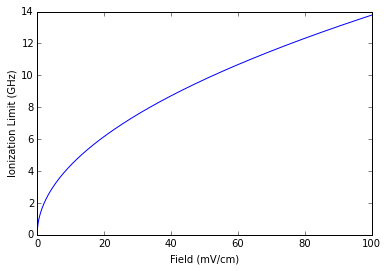

In [4]:
fAU1mVcm = 1.94469e-13
enAU1GHz = 1.51983e-7
f = np.linspace(0,100,10000)
f = f[1:]
eion = enAU1GHz*4*(f/fAU1mVcm)**0.5

plt.plot(f, eion)
plt.xlabel('Field (mV/cm)')
plt.ylabel('Ionization Limit (GHz)')

In [5]:
steps=int(round(((299792458.0/(15.9332*1e9)*1000)/0.0002539*(3/2)),0)+1)
steps = 111600
stages = 600
print("steps = \t",steps)
stsg = steps/stages
print("per stage = \t",stsg)
f = 15.9332
print("frequency = \t {:.4} GHz".format(f))
w = wavelength(steps, f)
print("wavelengths = \t {:.3f}".format(w))


steps = 	 111600
per stage = 	 186.0
frequency = 	 15.93 GHz
wavelengths = 	 3.013


In [6]:
1.0/0.0002539

3938.558487593541

1_mwa.txt
Gauss f0 =  15.93221 +/- 0.0001  GHz
Gauss FWHM =  0.0041 +/- 0.0002  GHz
Cauchy f0 =  15.93216 +/- 0.0001  GHz
Cauchy FWHM =  0.0036 +/- 0.0003  GHz


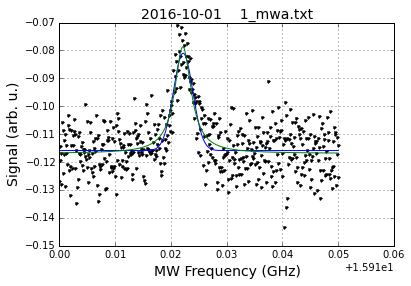

In [6]:
mwa_scan(1)
f = 15.9320

5_delay.txt
mean =  0.0481 +/- 0.0002
pk-pk =  0.0091 +/- 0.0005
phase =  1.31 +/- 0.01


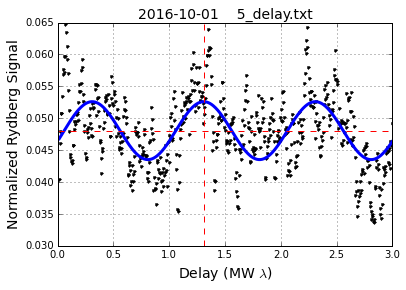

In [10]:
delay_scan(5,f,n_ave=3)

6_delay.txt
mean =  0.032 +/- 0.0002
pk-pk =  0.0069 +/- 0.0005
phase =  0.81 +/- 0.01


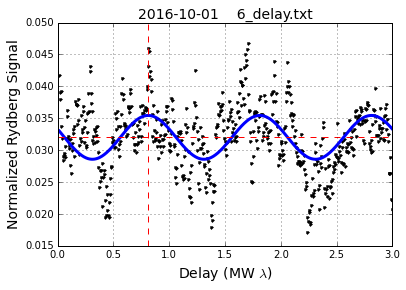

In [11]:
delay_scan(6,f,n_ave=3)

6_delay.txt
mean =  0.032 +/- 0.0002
pk-pk =  0.0069 +/- 0.0005
phase =  0.81 +/- 0.01


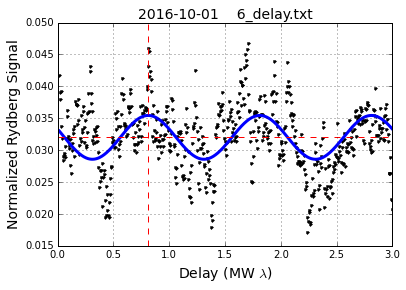

In [14]:
delay_scan(6,f,n_ave=3)

38_delay.txt
mean =  0.047 +/- 0.0002
pk-pk =  0.0095 +/- 0.0005
phase =  0.874 +/- 0.009


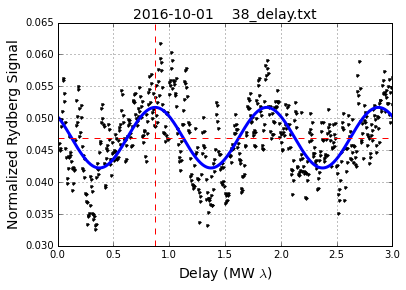

In [15]:
delay_scan(38,f,n_ave=3)

39_delay.txt
mean =  0.065 +/- 0.0002
pk-pk =  0.0167 +/- 0.0007
phase =  0.96 +/- 0.006


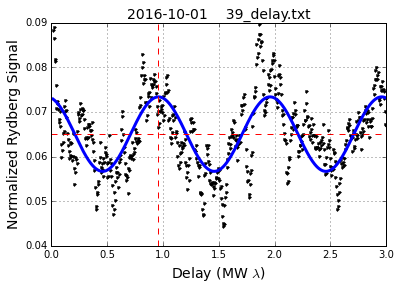

In [16]:
delay_scan(39,f,n_ave=3)